In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, prange

%matplotlib inline

In [42]:
# Declare parameters
#---------------------------------------
n_steps = 10001
nx = 40
T = 1
k = 0.5

# Create initial grid
grid_0 = np.zeros((nx + 2, nx + 2))
grid_0[1:-1, 1:-1] = np.random.choice([-1, 1], (nx,nx))


def Ising_model(J):
    # Create grid
    grid = grid_0.copy()
    
    # Create list to store Magnetization modulus
    M = np.zeros(n_steps + 1)
    
    for step in range(n_steps):
        
        # Randomly choose lattice site 
        M[step:] += abs(np.sum(grid))
        i, j = np.random.randint(1,41, 2)

        # Hamiltonian
        H = J*(grid[i - 1, j] + grid[i + 1, j] + grid[i, j - 1] + grid[i, j + 1])
        
        # Probability
        P = np.exp(-H*2*grid[i, j])

        # Update grid
        if P > np.random.sample():
            grid[i, j] = -grid[i, j]
        
    # Create figures        
    fig = plt.figure(facecolor='w', figsize=(12,4), dpi=80)
 
    ax = plt.subplot2grid((1, 3), (0, 0), colspan=2)
    ax.plot( M/(np.arange(1,n_steps+2)*(nx*nx)) , 'brown')
    ax.grid(b=True, which='major', c='k', alpha=0.2)
    ax.set_xlabel('n')
    ax.set_ylabel('<|M|>')
    ax.set_title('Magnetization modulus for J = %d' % J)
    
    ax = plt.subplot2grid((1, 3), (0, 2))
    ax.matshow(grid[1:-1, 1:-1], cmap = 'hot')
    ax.set_title('n = %i' % n_steps)
    ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    

k = 1 # Boltzmann constant
n_cell_id = 5 # Number of cells?
n_types = 3 # Number of cell types
N = 8 # Number of lattice sites?
n_steps = 10000 # Number of iterations
J = np.zeros((n_types + 1, n_types + 1)) # Cell grid?
lamb = 0.4 # something in Hvol, just a constant maybe
At = [0,16,19,12] # List where each index is the equilibrium area of a cell type

# THIS SHOULD BE RANDOMIZED!!

# No clue
id_to_type = np.array([0,2,1,3,2,1])

# Initial grid
grid_cell_0 = np.zeros((N + 2, N + 2), dtype=int)     
grid_cell_0[1:3,1:4] = 1
grid_cell_0[1:4, 4:9] = 2
grid_cell_0[3:9, 1:4] = 3
grid_cell_0[4:9, 4:6] = 4
grid_cell_0[4:9, 6:9] = 5
#grid_cell_0[]

J[0,0:n_types] = 0
J[1,0] = J[0,1]
J[1,1] = 1
J[1,2] = 0.5
J[1,3] = 0.4
J[2,0] = J[0,2]
J[2,1] = J[1,2]
J[2,2] = 1
J[2,3] = 0.8
J[3,0] = J[0,3]
J[3,1] = J[1,3]
J[3,2] = J[2,3]
J[3,3] = 1

def cellular_potts_model(J, At, lamb):
    T = 700
    grid = grid_cell_0.copy()
    
    plt.figure()
    plt.imshow(grid)
    plt.title('Initial grid') # Just to indentify the plot in output
    
    # List to save hamiltonian values each step?
    H = np.zeros(n_steps + 1) 
    # Initial hamiltonian of grid
    H_change = get_hamiltonian(J, At, lamb, grid)
    print(H_change)        
    
    for step in range(n_steps):
        H[step:] += H_change
        # Choose random lattice side
        i,j = np.random.randint(1,N+1,2)
        # Choose random neighbour (Moore)
        new_id = grid[i + np.random.randint(-1,2)][j + np.random.randint(-1,2)]
        
        # Calculate hamiltonian of grid if lattice side was changed to neighbour
        temp_grid = grid.copy()
        temp_grid[i][j] = new_id
        H_pos = get_hamiltonian(J, At, lamb, temp_grid)
        
        # Apply metropolis step
        H_change = H_pos - H[step]
        if H_change <= 0:
            grid[i][j] = new_id
        else:
            P = np.exp(-H_change/(k * T))
            if P > np.random.uniform():
                grid[i][j] = new_id
            else:
                H_change = 0
            # Lower temperature for simulated annealing?
            T = .9 * T
        
        # Show progression of grid each 1000 steps
        if step % 1000 == 0:
            plt.figure()
            plt.imshow(grid)
            plt.title('Grid at t=%d' % step) # Just to indentify the plot in output
    
    # Plot final grid
    fig = plt.figure(facecolor='w', figsize=(12,4), dpi=80)
 
    ax = plt.subplot2grid((1, 3), (0, 0), colspan=2)
    ax.plot( H , 'brown')
    ax.grid(b=True, which='major', c='k', alpha=0.2)
    ax.set_xlabel('n')
    ax.set_ylabel('H')
    #ax.set_title('Magnetization modulus for J = %d' % J)
    
    ax = plt.subplot2grid((1, 3), (0, 2))
    ax.matshow(grid[1:-1, 1:-1], cmap = 'hot')
    ax.set_title('n = %i' % n_steps)
    ax.axis('off')
    
    plt.tight_layout()
    plt.show()
        
        
def get_hamiltonian(J, At, lamb, grid):
    H_vol = 0
    # Exlude 0 which is the medium
    for i in range(1, n_cell_id + 1):
        a = np.count_nonzero(grid == i)
        H_vol += (a - At[id_to_type[i]])**2
    H_vol *= lamb
    H_bond = get_H_bond(J, grid, id_to_type)
    
    return H_vol + H_bond

#@njit(parallel = True)
def get_H_bond(J, grid, id_to_type):
    H_bond = 0
    for i in range(1, N + 1):
        for j in range(1, N+1):
            sigm = grid[i][j]
            type_s =  id_to_type[sigm]
            for k in [-1,0,1]:
                for l in [-1,0,1]:
                    sigm_neighbour = grid[i + k][j + l]
                    if not sigm == sigm_neighbour:
                        J_add = J[type_s,id_to_type[sigm_neighbour]]
                        H_bond += J_add
    return H_bond
    

190.19999999999993


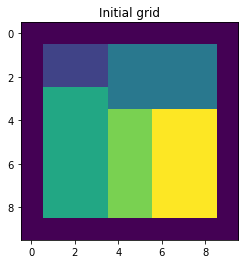

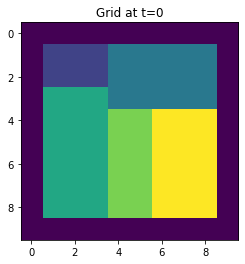

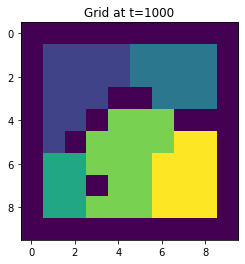

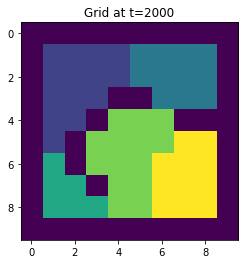

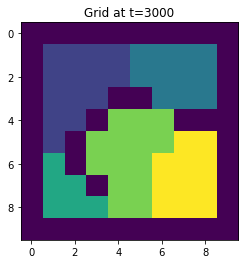

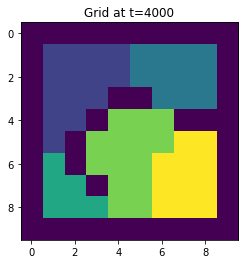

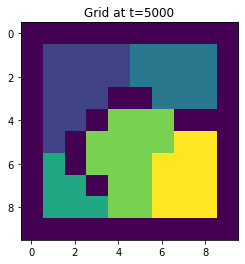

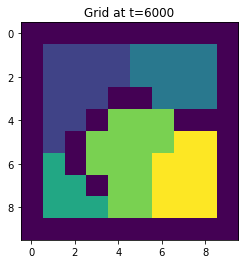

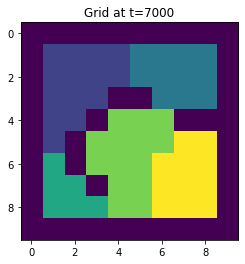

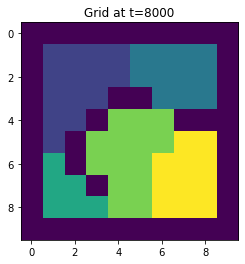

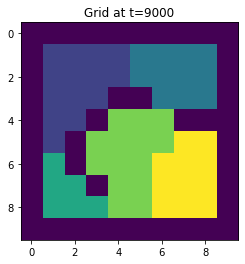

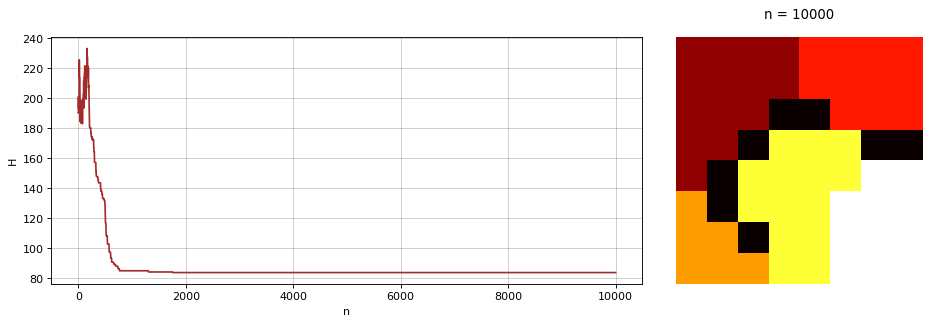

In [43]:
cellular_potts_model(J, At, lamb)

In [ ]:
for i in [-1, 0, 1]:
    Ising_model(i)
    
print(np.random.sample())